# 3. Project: Bank Customer Churn Prediction
## Business Value Analysis (Cost-Benefit)

**Objectives:**

- Convert technical indicators (Confusion Matrix) to monetary value (USD).

- Compare the profitability of using AI versus traditional strategies.

- Find the optimal "Threshold" to maximize profit.

**Financial Assumptions:**
1. **Cost of Retention:** $10 (Voucher/Call center) per customer predicted to leave.

2. **Loss of Customer Lifetime Value (LTV):** $500 (Bank's lost profit if the customer leaves).

3. **Scenarios:**

- **True Positive:** Spend $10, retain $500. -> **Profit $490**.

- **False Positive (False Alert):** Spend $10, customer didn't intend to leave. -> **Loss of $10**.

- **False Negative (Missed):** No spending, customer leaves. -> **Loss of $500** (Opportunity Cost).

- **True Negative (True Missed):** No spending, customer stays. -> **0**.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

current_dir = os.getcwd()
file_path = os.path.join(current_dir, '..', 'data', 'processed', 'BankChurners_Cleaned_Featured.csv')
df = pd.read_csv(file_path)

X = df.drop('Attrition_Flag', axis=1)
y = df['Attrition_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


current_dir = os.getcwd()
file_path = os.path.join(current_dir, '..', 'models','churn_prediction_pipeline.pkl')
model = joblib.load(file_path)
print("Model and Data have been loaded successfully.")

Model and Data have been loaded successfully.


## Calculate Profit based on Confusion Matrix
Define a function to calculate profit based on the formula you provided.

In [ ]:
def calculate_profit(y_true, y_pred, cost=10, ltv=500):
    """

    Profit calculation based on the Confusion Matrix.

    Args:
    Cost: Marketing/voucher cost to retain a customer.
    LTV: Customer lifetime value (profit earned if they stay).

"""
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # 1. Profit from catching the right target (True Positive)
    # We incurred a 'cost' but saved the 'ltv'    
    benefit = tp * (ltv - cost)
    
    #2. Wasted Costs on False Alarms (False Positive)
    # We pay the 'cost' but this customer never intended to come.    
    waste = fp * cost
    
    # Total net profit of the campaign (compared to doing nothing)    
    total_profit = benefit - waste
    
    return total_profit, cm

print("The financial function has been defined.")

The financial function has been defined.


## Baseline Comparison
Comparing the effectiveness of AI Models with two traditional strategies:
1. **No Action:** Ignoring customer churn. Campaign profit = $0. (But losing all the LTV of churning customers).

2. **Mass Campaign:** Giving $10 vouchers to ALL customers as a sure bet.

Campaign Profit (Test Set 2026 customers):
1. Do nothing: $0
2. Send all: $142,240
3. Use AI Model: $141,890


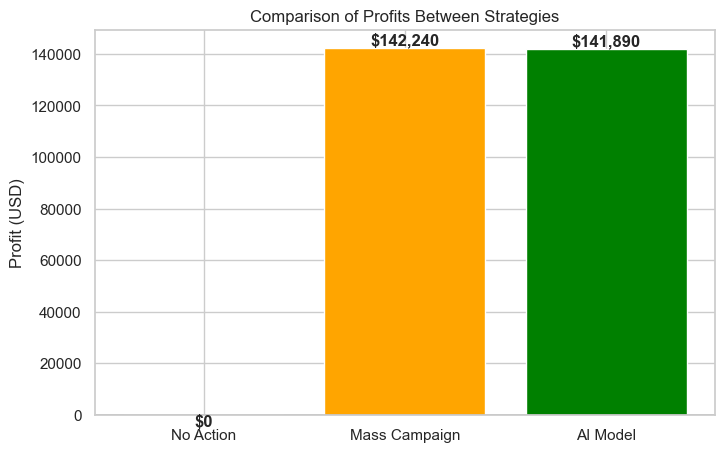

In [4]:
# --- Strategy 1: No Action ---
# Doing nothing -> No cost, no retention.
profit_no_action = 0 

# --- Strategy 2: Mass Campaign (Send to everyone in the Test Group) ---
# Assume all predictions are the same (Churn)
y_all_churn = np.ones_like(y_test)
profit_mass, cm_mass = calculate_profit(y_test, y_all_churn)

# --- Strategy 3: AI Model (Default Threshold 0.5) ---
y_pred_ai = model.predict(X_test)
profit_ai, cm_ai = calculate_profit(y_test, y_pred_ai)

# Display results
print(f"Campaign Profit (Test Set {len(y_test)} customers):")
print(f"1. Do nothing: ${profit_no_action:,.0f}")
print(f"2. Send all: ${profit_mass:,.0f}")
print(f"3. Use AI Model: ${profit_ai:,.0f}")

# Draw a comparison chart
strategies = ['No Action', 'Mass Campaign', 'AI Model']
profits = [profit_no_action, profit_mass, profit_ai]

plt.figure(figsize=(8, 5))
bars = plt.bar(strategies, profits, color=['gray', 'orange', 'green'])
plt.title('Comparison of Profits Between Strategies')
plt.ylabel('Profit (USD)')
plt.axhline(0, color='black', linewidth=1) # Horizontal line at level 0

# Add data to the column
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"${yval:,.0f}", va='bottom' if yval > 0 else 'top', ha='center', fontweight='bold')

plt.show()

## Threshold Optimization
By default, the model sets a threshold of 0.5 (a probability > 50% is considered a crunch).

However, since the benefit of catching the right customer ($490) far outweighs the cost of catching the wrong one ($10), we should **LOWER THE THRESHOLD** to catch more customers, even if it means accepting a slightly higher number of wrong customers.

We will run a loop from 0% to 100% to find the "Sweet Spot" that generates the most money.

In [5]:
# Use the forecast probability instead of the label 0/1
y_probs = model.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0, 1, 101) # Runs from 0.00 to 1.00
profits = []

for t in thresholds:
    # If the probability > t, the prediction is 1; otherwise, it is 0.
    y_pred_t = (y_probs >= t).astype(int)
    p, _ = calculate_profit(y_test, y_pred_t)
    profits.append(p)

# Find the highest profit and the corresponding threshold
max_profit = max(profits)
best_threshold = thresholds[np.argmax(profits)]

print(f"Maximum profit achievable: ${max_profit:,.0f}")
print(f"At the threshold: {best_threshold:.2f}")
print(f"Increase by: ${max_profit - profit_ai:,.0f} compared to the default threshold of 0.5")

Maximum profit achievable: $156,200
At the threshold: 0.02
Increase by: $14,310 compared to the default threshold of 0.5


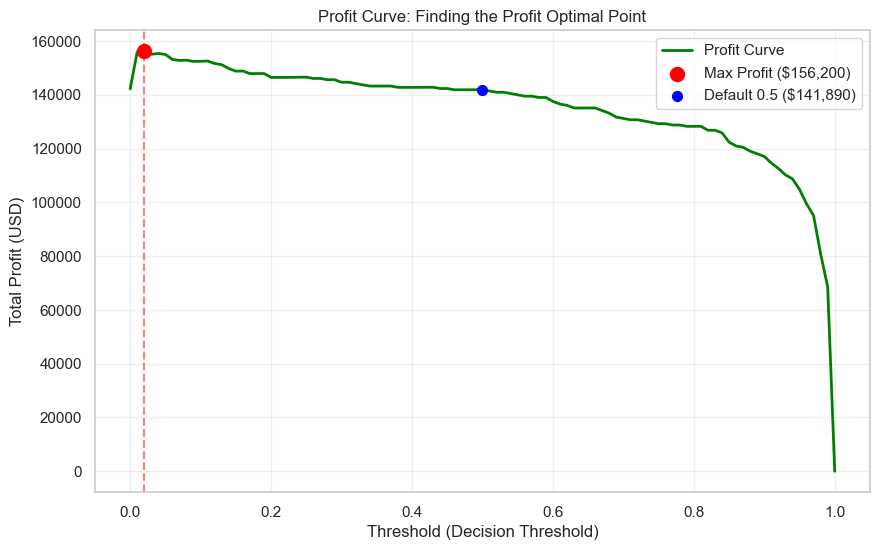

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, profits, label='Profit Curve', color='green', linewidth=2)

# Mark the optimal point
plt.scatter(best_threshold, max_profit, color='red', s=100, zorder=5, label=f'Max Profit (${max_profit:,.0f})')
plt.axvline(best_threshold, color='red', linestyle='--', alpha=0.5)

# Mark the default score as 0.5
default_profit = profits[50] # index 50 corresponds to 0.5
plt.scatter(0.5, default_profit, color='blue', s=50, zorder=5, label=f'Default 0.5 (${default_profit:,.0f})')

plt.title('Profit Curve: Finding the Profit Optimal Point')
plt.xlabel('Threshold (Decision Threshold)')
plt.ylabel('Total Profit (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Final Recommendation
Based on the financial analysis, we make the final decision for the operations team (Marketing/Sales).

In [9]:
print("=== OPERATIONAL RECOMMENDATION REPORT ===")
print(f"1. Do not use the default threshold of 0.5. Set the system to: {best_threshold:.2f}")
print(f" (Meaning: Any customer with a risk of leaving > {best_threshold*100:.0f}% should be given a $10 Voucher).")
print(f"2. Total expected profit on the Test group (20% of customers): ${max_profit:,.0f}")
print(f"3. If implemented on the entire customer group (5 times), estimated profit: ${max_profit * 5:,.0f}")

=== OPERATIONAL RECOMMENDATION REPORT ===
1. Do not use the default threshold of 0.5. Set the system to: 0.02
 (Meaning: Any customer with a risk of leaving > 2% should be given a $10 Voucher).
2. Total expected profit on the Test group (20% of customers): $156,200
3. If implemented on the entire customer group (5 times), estimated profit: $781,000
